In [91]:
import numpy as np
import matplotlib.pyplot as plt

In [230]:
#Overtopping formule non breaking waves

def overtopping_non_breaking(
    Hm0,
    Rc,
    sm10,
    Dn50,
    B,              # bermbreedte
    BL,             # bermniveau
    Hm0_swell=0.0, 
    gamma_v=1.0, 
    alpha_deg=53.15, 
    g=9.81
):
    """
    EurOtop / Van Gent overtopping – non-breaking waves
    alpha in GRADEN
    """

    if Hm0 <= 0 or sm10 <= 0:
        return 0.0, 0.0

    # --------------------------------------------------
    # 0. Trigonometrie in graden
    # --------------------------------------------------
    alpha_rad = np.deg2rad(alpha_deg)
    tan_alpha = np.tan(alpha_rad)
    cot_alpha = 1.0 / tan_alpha

    # --------------------------------------------------
    # 1. Gamma_f (frictie)
    # --------------------------------------------------
    gamma_f1 = 1.0 - 0.7 * (Dn50 / Hm0)**0.05

    if sm10 >= 0.012:
        gamma_f = gamma_f1
    elif 0.0006 < sm10 < 0.012:
        gamma_f = gamma_f1 + 12.0 * (0.012 - sm10) * (1.0 - gamma_f1)

    gamma_f = np.clip(gamma_f, 0.01, 1.0)

    # --------------------------------------------------
    # 2. Gamma_b (berm)
    # --------------------------------------------------
    if cot_alpha <= 4.0:
        term1 = (sm10 * B) / Hm0
        term2 = BL / (sm10 * Rc)
        term2 = max(0.0, term2)

        gamma_b = 1.0 - 18.0 * term1**1.3 * (1.0 - 0.34 * term2**0.2)
        gamma_b = np.clip(gamma_b, 0.4, 1.0)
    else:
        gamma_b = 1.0

    # --------------------------------------------------
    # 3. Hoofdformule (B2)
    # --------------------------------------------------
    xi_m10 = tan_alpha / np.sqrt(sm10)

    denominator = (
        gamma_f *
        gamma_b *
        gamma_v *
        xi_m10**0.24 *
        Hm0
    )

    exponent = -2.5 * (Rc - 0.4 * Hm0_swell) / denominator
    exponent = np.clip(exponent, -100, 100)

    q_star = 0.8 * cot_alpha * np.exp(exponent)
    q = q_star * np.sqrt(g * Hm0**3)

    return q, q_star


In [239]:
# Maximum overtopping functie
import pandas as pd
import numpy as np

def max_wave_overtopping_table(
    Hm0_array,
    R_c_array,
    steepness_list,
    alpha_deg,
    Dn50,
    berm_width,
    berm_levels,      # array met dezelfde lengte als R_c_array
    duration_s,          
    width=0.60,          
    Hm0_swell=0.0,
    gamma_v=1.0,
    g=9.81
):
    """
    Berekent overtopping discharge q en totaal volume
    voor alleen de maximale Hm0. 
    Elke Rc heeft een corresponderende berm_level.
    """
    Hm0_max = np.max(Hm0_array)
    rows = []

    # check dat R_c_array en berm_levels dezelfde lengte hebben
    assert len(R_c_array) == len(berm_levels), "R_c_array en berm_levels moeten dezelfde lengte hebben"

    for sm in steepness_list:
        for Rc, BL in zip(R_c_array, berm_levels):

            q, q_star = overtopping_non_breaking(
                Hm0=Hm0_max,
                Rc=Rc,
                alpha_deg=alpha_deg,
                sm10=sm,
                Dn50=Dn50,
                B=berm_width,
                BL=BL,
                Hm0_swell=Hm0_swell,
                gamma_v=gamma_v,
                g=g
            )

            volume = q * duration_s * width

            rows.append({
                "water_level [m]": BL,  # corresponds to berm_level
                "steepness sm-1,0 [-]": sm,
                "Rc [m]": Rc,
                "Hm0_max [m]": Hm0_max,
                "Rc/Hm0 [-]": Rc / Hm0_max,
                "q* [-]": q_star,
                "q [m3/s/m]": q,
                "Volume [m3]": volume
            })

    return pd.DataFrame(rows)

max_wave_overtopping_table(
    Hm0, R_c, steepness, alpha_deg=53.15, Dn50=0.05, berm_width=berm_width1, berm_levels=h_b, duration_s=1200)

,water_level [m],"steepness sm-1,0 [-]",Rc [m],Hm0_max [m],Rc/Hm0 [-],q* [-],q [m3/s/m],Volume [m3]
0,0.013,0.02,0.163,0.3,0.543333,0.060697,0.031238,22.491484
1,0.000,0.02,0.150,0.3,0.500000,0.067857,0.034923,25.144700
2,-0.050,0.02,0.100,0.3,0.333333,0.140285,0.072198,51.982792
3,0.013,0.04,0.163,0.3,0.543333,0.041360,0.021286,15.326027
4,0.000,0.04,0.150,0.3,0.500000,0.041908,0.021568,15.529087
5,-0.050,0.04,0.100,0.3,0.333333,0.101737,0.052359,37.698659


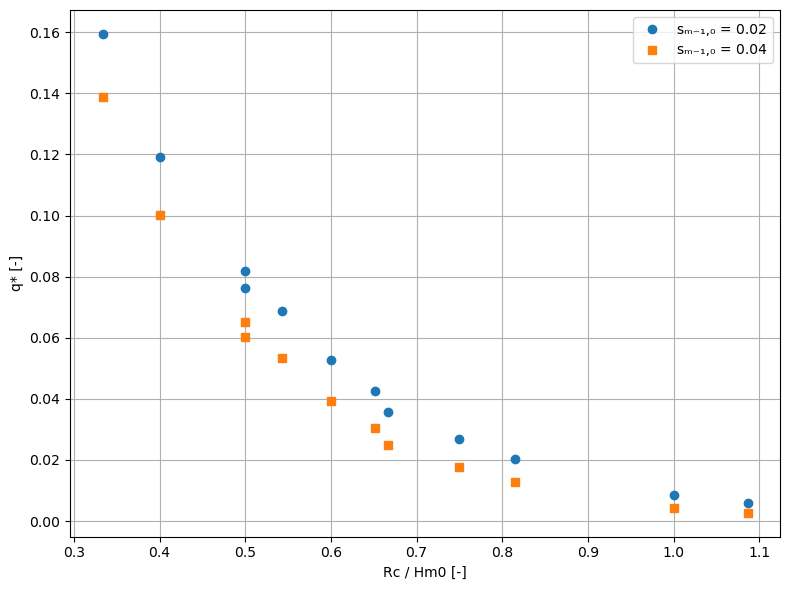

In [233]:
#Uitprobeer plot voor different steepnesses

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

markers = ['o', 's', '^', 'D']  # verschillende markers indien gewenst

for i, sm in enumerate(steepness):

    first_point = True  # voor legend

    for k in range(len(waterlevels)):
        for j in range(len(Hm0)):

            q, q_star = overtopping_non_breaking(
                Hm0[j],
                R_c[k],
                alpha_deg=53.15,
                sm10=sm,
                Dn50=Dn50,
                B=berm_width1,
                BL=berm_level1,
                Hm0_swell=0.0,
                gamma_v=1.0,
                g=9.81
            )

            label = f"sₘ₋₁,₀ = {sm}" if first_point else None

            plt.plot(
                R_c[k] / Hm0[j],
                q_star,
                marker=markers[i],
                linestyle='',
                label=label,
                color=f"C{i}"
            )

            first_point = False

# Plot opmaak
plt.xlabel("Rc / Hm0 [-]")
plt.ylabel("q* [-]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [234]:
#CONSTANTS

Dn50 = 0.04 #m
toe_height_input = 0.055  
toe_width_input = 0.083   
toe_slope_h = 2          
toe_slope_v = 1


In [235]:
# Cross section 1
berm_level1 = 0.55# m
waterlevels = np.array([berm_level1 - 0.013, berm_level1, berm_level1 + 0.05])  # mNAP
h_b = np.array([berm_level1-waterlevels[0], berm_level1-waterlevels[1], berm_level1-waterlevels[2]])  
crest_height1 = 0.7  # mNAP
crest_width1 = 0.091  # m
berm_width1 = 0.21  # m
R_c = np.array([crest_height1 - waterlevels[0], crest_height1 - waterlevels[1], crest_height1 - waterlevels[2]])  #m
H_s = 0.25
Hm0 = np.array([0.6*H_s, 0.8*H_s, H_s, 1.2*H_s])  #m
steepness = [0.02, 0.04]


C:\Users\bauke\AppData\Local\Temp\ipykernel_26664\3245722929.py:67: RuntimeWarning: invalid value encountered in scalar power
  xi_m10**0.24 *


,"steepness sm-1,0 [-]",Rc [m],Hm0_max [m],Rc/Hm0 [-],q* [-],q [m3/s/m],Volume [m3]
0,0.02,0.119,0.35,0.340000,NaN,NaN,NaN
1,0.02,0.106,0.35,0.302857,NaN,NaN,NaN
2,0.02,0.056,0.35,0.160000,NaN,NaN,NaN
3,0.04,0.119,0.35,0.340000,NaN,NaN,NaN
4,0.04,0.106,0.35,0.302857,NaN,NaN,NaN
5,0.04,0.056,0.35,0.160000,NaN,NaN,NaN


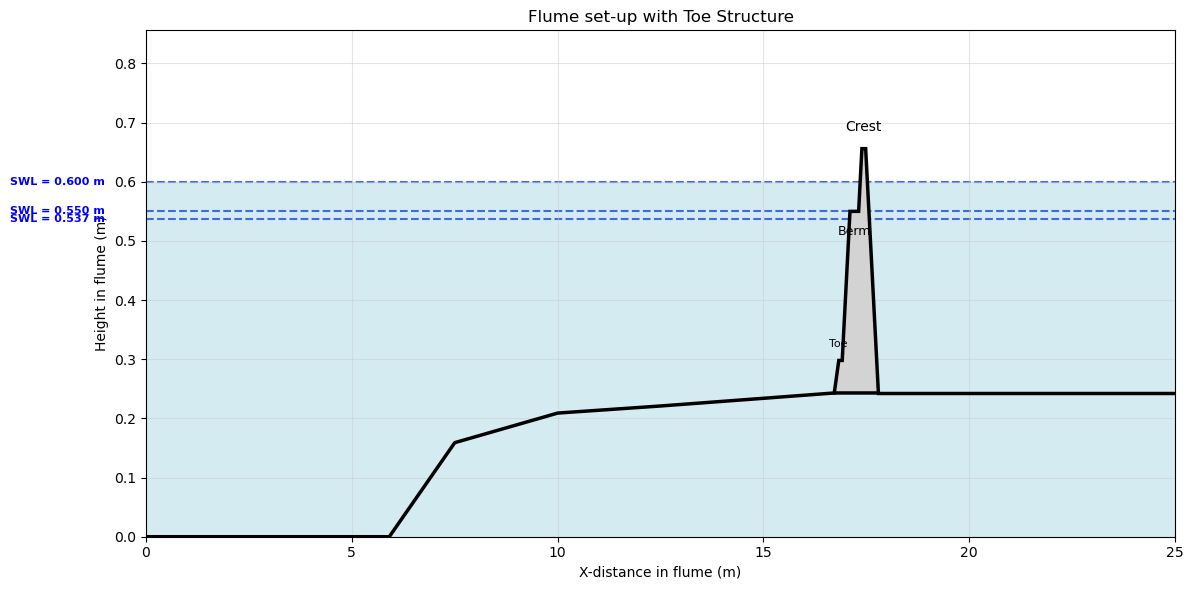

In [191]:
#Wave flume plot inclusief breakwater

import numpy as np
import matplotlib.pyplot as plt

def plot_breakwater_with_toe(
    crest_height,
    berm_level,
    waterlevels,
    berm_width,
    crest_width,
    # Inputs voor de Toe (Teen)
    toe_width,
    toe_height, 
    toe_slope_H=2, 
    toe_slope_V=3,
    # Inputs voor Main Structure
    slope_H=3,
    slope_V=4
):
    # --- 1. VASTE BATHYMETRIE ---
    x_fixed = np.array([0.0, 5.0, 5.91, 7.5, 10.0, 12.5, 15.0, 16.72])
    z_fixed = np.array([0.0, 0.0, 0.0, 0.159, 0.209, 0.221, 0.234, 0.243])
    
    start_x = x_fixed[-1]
    start_z = z_fixed[-1] 

    # --- 2. CONSTRUCTIE GEOMETRIE ---
    main_slope_ratio = slope_H / slope_V
    toe_slope_ratio = toe_slope_H / toe_slope_V

    # A. De Teen
    z_toe_top = start_z + toe_height
    dx_toe_front = toe_height * toe_slope_ratio
    x_toe_top_start = start_x + dx_toe_front
    
    x_toe_back = x_toe_top_start + toe_width
    z_toe_back = z_toe_top

    # B. Hoofdtalud naar Berm
    dz_to_berm = berm_level - z_toe_back
    dx_to_berm = dz_to_berm * main_slope_ratio
    x_berm_start = x_toe_back + dx_to_berm
    
    # C. Horizontale Berm
    x_berm_end = x_berm_start + berm_width
    
    # D. Helling naar Crest
    dz_to_crest = crest_height - berm_level
    dx_to_crest = dz_to_crest * main_slope_ratio
    x_crest_start = x_berm_end + dx_to_crest
    
    # E. Horizontale Crest
    x_crest_end = x_crest_start + crest_width
    
    # F. Achterkant
    dz_down = crest_height - start_z
    dx_down = dz_down * main_slope_ratio
    x_end = x_crest_end + dx_down

    # Samenstellen
    x_bw = np.array([start_x, x_toe_top_start, x_toe_back, x_berm_start, x_berm_end, x_crest_start, x_crest_end, x_end])
    z_bw = np.array([start_z, z_toe_top,       z_toe_back, berm_level,  berm_level, crest_height, crest_height, start_z])

    # --- 3. PLOTTEN ---
    fig, ax = plt.subplots(figsize=(12, 6))

    # AANPASSING 1: Water doortrekken tot 25m
    wl_max = np.max(waterlevels)
    ax.fill_between([0, 25.0], 0, wl_max, color="#d4ebf2", alpha=1.0, zorder=0)

    # Bathymetrie (vooroever)
    ax.plot(x_fixed, z_fixed, color="black", linewidth=2.5, zorder=2)

    # Breakwater
    ax.fill(x_bw, z_bw, color="lightgrey", edgecolor="black", linewidth=2.5, zorder=3)
    # Hulplijn teen
    ax.plot([x_toe_back, x_toe_back], [start_z, z_toe_back], 'k--', linewidth=0.5, alpha=0.5)

    # AANPASSING 2: Golfbak doortrekken
    # We tekenen een lijn vanaf het einde van de constructie (x_end) tot 25m
    # op de hoogte waarop de constructie begon/eindigde (start_z).
    ax.plot([x_end, 25.0], [start_z, start_z], color="black", linewidth=2.5, zorder=2)

    # Waterniveaus
    for wl in waterlevels:
        ax.axhline(wl, linestyle="--", linewidth=1.5, color="royalblue", zorder=1)
        
        ax.text(
            -0.04, wl, 
            f"SWL = {wl:.3f} m", 
            color="blue", fontsize=8, fontweight='bold', zorder=4,
            transform=ax.get_yaxis_transform(), 
            ha="right", 
            va="center"
        )

    # Labels
    ax.text((x_crest_start + x_crest_end)/2, crest_height + 0.03, "Crest", ha="center", fontsize=10, zorder=4)
    ax.text((x_berm_start + x_berm_end)/2, berm_level - 0.04, "Berm", ha="center", fontsize=9, zorder=4)
    ax.text((start_x + x_toe_back)/2, z_toe_top + 0.02, "Toe", ha="center", va="bottom", fontsize=8, rotation=0, zorder=4)

    # Assen
    ax.set_xlabel("X-distance in flume (m)")
    ax.set_ylabel("Height in flume (m)")
    
    # AANPASSING 3: Limiet van de as op 25 zetten
    ax.set_xlim(0, 25)
    
    ax.set_ylim(0, max(crest_height1, wl_max) + 0.2)
    ax.grid(True, color='#cccccc', linestyle='-', alpha=0.5, zorder=0)
    ax.set_title("Flume set-up with Toe Structure")
    
    plt.tight_layout()
    plt.show()

# Inputs (deze worden overgenomen uit je eerdere context)
# Zorg dat deze variabelen gedefinieerd zijn voordat je de functie aanroept
# (Hieronder staan ze ingevuld voor de zekerheid)



plot_breakwater_with_toe(
    crest_height=crest_height1,
    berm_level=berm_level1,
    waterlevels=waterlevels,
    berm_width=berm_width1,
    crest_width=crest_width1,
    toe_width=toe_width_input,
    toe_height=toe_height_input,
    toe_slope_H=toe_slope_h,
    toe_slope_V=toe_slope_v
)

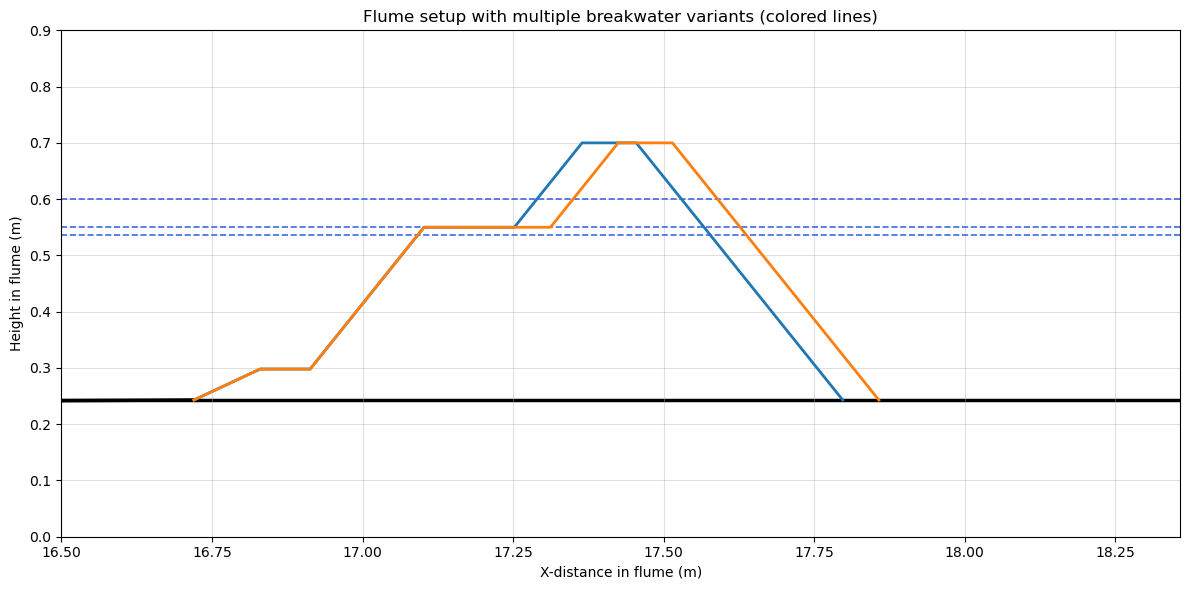

In [192]:
# Plot for different breakwater configurations
def multiple_configurations_plot(
    crest_heights,
    berm_levels,
    waterlevels,
    berm_widths,
    crest_widths,
    toe_width,
    toe_height,
    toe_slope_H=2,
    toe_slope_V=3,
    slope_H=3,
    slope_V=4,
    line_width=2.0,
    x_start_plot=16.5
):
    # --- 1. VASTE BATHYMETRIE ---
    x_fixed = np.array([0.0, 5.0, 5.91, 7.5, 10.0, 12.5, 15.0, 16.72])
    z_fixed = np.array([0.0, 0.0, 0.0, 0.159, 0.209, 0.221, 0.234, 0.243])
    start_x = x_fixed[-1]
    start_z = z_fixed[-1]

    main_slope_ratio = slope_H / slope_V
    toe_slope_ratio = toe_slope_H / toe_slope_V

    fig, ax = plt.subplots(figsize=(12, 6))

    all_bw_coords = []  # om te checken op overlap
    colors = plt.cm.tab10.colors
    color_idx = 0
    x_end_all = []

    # --- 2. BREAKWATER VARIANTEN ---
    for crest_h in crest_heights:
        for berm_lvl in berm_levels:
            for berm_w in berm_widths:
                for crest_w in crest_widths:

                    # Toe
                    z_toe_top = start_z + toe_height
                    dx_toe_front = toe_height * toe_slope_ratio
                    x_toe_top_start = start_x + dx_toe_front
                    x_toe_back = x_toe_top_start + toe_width

                    # Naar berm
                    dz_to_berm = berm_lvl - z_toe_top
                    dx_to_berm = dz_to_berm * main_slope_ratio
                    x_berm_start = x_toe_back + dx_to_berm
                    x_berm_end = x_berm_start + berm_w

                    # Naar crest
                    dz_to_crest = crest_h - berm_lvl
                    dx_to_crest = dz_to_crest * main_slope_ratio
                    x_crest_start = x_berm_end + dx_to_crest
                    x_crest_end = x_crest_start + crest_w

                    # Achtertalud
                    dz_down = crest_h - start_z
                    dx_down = dz_down * main_slope_ratio
                    x_end = x_crest_end + dx_down

                    x_bw = [
                        start_x,
                        x_toe_top_start,
                        x_toe_back,
                        x_berm_start,
                        x_berm_end,
                        x_crest_start,
                        x_crest_end,
                        x_end
                    ]
                    z_bw = [
                        start_z,
                        z_toe_top,
                        z_toe_top,
                        berm_lvl,
                        berm_lvl,
                        crest_h,
                        crest_h,
                        start_z
                    ]

                    # Check of deze lijn exact overlapt met een eerdere
                    is_duplicate = any(
                        np.allclose(x_bw, prev_x) and np.allclose(z_bw, prev_z)
                        for prev_x, prev_z in all_bw_coords
                    )

                    color = "black" if is_duplicate else colors[color_idx % len(colors)]
                    if not is_duplicate:
                        color_idx += 1

                    ax.plot(
                        x_bw,
                        z_bw,
                        color=color,
                        linewidth=line_width,
                        zorder=3
                    )

                    all_bw_coords.append((x_bw, z_bw))
                    x_end_all.append(x_end)

    # --- 3. ROBUUSTE BATHYMETRIE (INTERPOLATIE) ---
    z_start = np.interp(x_start_plot, x_fixed, z_fixed)
    mask = x_fixed > x_start_plot
    x_bathy = np.concatenate(([x_start_plot], x_fixed[mask]))
    z_bathy = np.concatenate(([z_start], z_fixed[mask]))
    ax.plot(x_bathy, z_bathy, color="black", linewidth=2.5, zorder=2)

    # --- 4. Achterste horizontale bodemlijn (zwart) ---
    x_max = max(x_end_all) + 0.5
    ax.plot([x_start_plot, x_max], [start_z, start_z], color="black", linewidth=2.5, zorder=1)

    # --- 5. Waterniveau ---
    for wl in waterlevels:
        ax.axhline(wl, linestyle="--", color="royalblue", linewidth=1.2)

    # --- 6. Assen & opmaak ---
    ax.set_xlim(x_start_plot, x_max)
    ax.set_ylim(0, max(max(crest_heights), max(waterlevels)) + 0.2)
    ax.set_xlabel("X-distance in flume (m)")
    ax.set_ylabel("Height in flume (m)")
    ax.set_title("Flume setup with multiple breakwater variants (colored lines)")
    ax.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()


multiple_configurations_plot(
    crest_heights=[0.7],
    berm_levels=[0.55],
    berm_widths=[0.15, 0.21],
    crest_widths=[0.09],
    waterlevels=waterlevels,
    toe_width=toe_width_input,
    toe_height=toe_height_input,
    toe_slope_H=toe_slope_h,
    toe_slope_V=toe_slope_v
)